## 函数

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore,ttest_ind,ttest_rel,pearsonr,spearmanr,ttest_1samp,wilcoxon

sns.set(font_scale=1.5,style="white")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
def fill_nan(df):
    # 确保列名是整数类型
    df.columns = range(df.shape[1])
    nan_locations = df.isna().stack()[df.isna().stack()].index.tolist()
    for loc in nan_locations:
        row, col = loc
        if col == 0:  # 最左列
            df.iloc[row, col] = np.nanmean(df.iloc[row, col+1:col+3])
        elif col == df.shape[1] - 1:  # 最右列
            df.iloc[row, col] = np.nanmean(df.iloc[row, col-2:col])
        else:  # 其他位置
            df.iloc[row, col] = np.nanmean(df.iloc[row, col-1:col+2])
    
    # 恢复原始列名
    df.columns = df.columns.astype(str)
    return df

def check_df(df):
    # 保存原始列名
    cols = df.columns
    df = fill_nan(df)
    df.columns = cols
    return df
    
def read_bold(sub,run_label):
    bold_ctx = pd.read_csv(os.path.join(bold_path,sub,run_label,schaefer+'.csv'))
    bold_sub = pd.read_csv(os.path.join(bold_path,sub,run_label,'hcp.csv'))
    bold = pd.concat([bold_ctx,bold_sub],axis=1)
    bold = check_df(bold)
    return bold

In [3]:
def fisher_z_transform(r, epsilon=1e-10):
    r_clipped = np.clip(r, -1 + epsilon, 1 - epsilon)
    return 0.5 * np.log((1 + r_clipped) / (1 - r_clipped))

In [4]:
demo_info = pd.read_csv('/data/dy/TIS_MDD/demo_info.csv',index_col=0)
demo_info['sub_id'] = demo_info.index
demo_info['sex_id'] = [1 if i=='M' else 0 for i in demo_info['sex']]

def fun_add_demo_time(data,run_label):
    data = pd.concat([data,demo_info],axis=1)
    data['time'] = [run_label for i in range(data.shape[0])]
    data = data.dropna(axis=0)
    return data

def fun_concat(data1,data2):
    df = pd.concat([data1,data2],axis=1)
    df = df.dropna(axis=0)
    cut_ = int(df.shape[1]/2)
    data = pd.concat([df.iloc[:,:cut_],df.iloc[:,cut_:]])
    return data

In [5]:
import statsmodels.api as sm

def get_dissim(run_label_2):
    run_label_1 = 'baseline'
    result = []
    index_ls = []
    for sub in sub_ls:
        if(len(os.listdir(os.path.join(bold_path,sub,run_label_2)))!=0):
            
            bold_1 = read_bold(sub,run_label_1);bold_2 = read_bold(sub,run_label_2)
            fc_1 = np.corrcoef(bold_1.T);fc_2 = np.corrcoef(bold_2.T)
            between = np.array([1-pearsonr(fc_1[i,:],fc_2[i,:])[0] for i in range(n_roi)])
            
            third1 = int(bold_1.shape[0]/3);third2 = int(bold_1.shape[0]*2/3)
            fc_11 = np.corrcoef(bold_1.iloc[:third1,:].T);fc_12 = np.corrcoef(bold_1.iloc[third2:,:].T)
            within1 = np.array([1-pearsonr(fc_11[i,:],fc_12[i,:])[0] for i in range(n_roi)])
            
            third1 = int(bold_2.shape[0]/3);third2 = int(bold_2.shape[0]*2/3)
            fc_21 = np.corrcoef(bold_2.iloc[:third1,:].T);fc_22 = np.corrcoef(bold_2.iloc[third2:,:].T)
            within2 = np.array([1-pearsonr(fc_21[i,:],fc_22[i,:])[0] for i in range(n_roi)])
            
            within = (within1+within2)/2
            ## fisher z-transform
            #within = np.array([fisher_z_transform(i) for i in within])
            #between = np.array([fisher_z_transform(i) for i in between])
            
            within = sm.add_constant(within)
            model = sm.OLS(between, within).fit()
            dissim = model.resid + model.params[0]
            
            result.append(dissim)
            index_ls.append(sub)
    return pd.DataFrame(result,index=index_ls,columns=roi_ls)

In [6]:
def regress_out(df,y_ls,x_ls):
    Y = np.array(df.loc[:,y_ls]);x = np.array(df.loc[:,x_ls])
    x = sm.add_constant(x);model = sm.OLS(Y, x).fit();Y_resid = model.resid + model.params[0]
    return Y_resid

In [8]:
def p_star(p):
    if(p>0.05):
        return 'n.s.'
    elif(p>0.01):
        return '*'
    elif(p>0.001):
        return '**'
    else:
        return '***'

## 分析

In [19]:
timepoints = ['1st_201','1st_301','5th_201','5th_301','5th_after','4weeks']

schaefer = '200'
atlas = pd.read_csv(f"/data/dy/atlas/schaefer{schaefer}x7_MNI.csv")
RSNs = ['Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','Default']
ICNs = RSNs+['Sub']
icn_ls = atlas['ICN'].tolist()+['Sub' for _ in range(19)]
n_roi = int(schaefer)+19
upper_mask = np.triu(np.ones((n_roi, n_roi), dtype=bool), k=1)

bold_path = '/data/dy/TIS_MDD/BOLD'
sub_ls = os.listdir(bold_path)

roi_ls = read_bold(sub_ls[0],'baseline').columns.tolist()
atlas['Name'] = roi_ls[:-19]

平均值：0.15	p值：6.083e-01
平均值：0.19	p值：5.122e-08
平均值：0.15	p值：1.770e-08
平均值：0.18	p值：6.661e-06


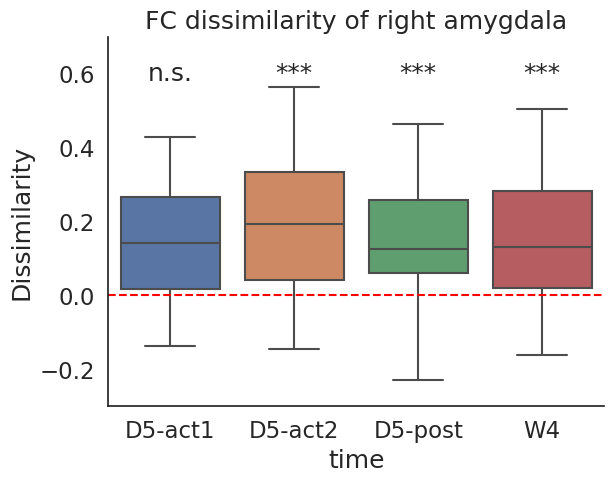

In [20]:
seed = ['AMYGDALA_RIGHT']

a = get_dissim('5th_201')
b = get_dissim('5th_301')
c = get_dissim('5th_after')
d = get_dissim('4weeks')

e = pd.concat([fun_add_demo_time(np.mean(a.loc[:,seed],1),'5th_201'),
               fun_add_demo_time(np.mean(b.loc[:,seed],1),'5th_301'),
               fun_add_demo_time(np.mean(c.loc[:,seed],1),'5th_after'),
               fun_add_demo_time(np.mean(d.loc[:,seed],1),'4weeks')])
e.columns = ['dissim','sex','age','sub_id','sex_id','time']
sns.boxplot(data=e,x='time',y='dissim',showfliers=False)
plt.axhline(0,color='red',linestyle='--')
plt.ylim(-0.3,0.7)
plt.title('FC dissimilarity of right amygdala')
plt.ylabel('Dissimilarity')
plt.xticks([i for i in range(4)],['D5-act1','D5-act2','D5-post','W4'])
for i,time in np.ndenumerate(['5th_201','5th_301','5th_after','4weeks']):
    df = e[e['time']==time]
    mean = np.mean(df['dissim'])
    df = regress_out(df,['dissim'],['sex_id','age'])
    _,p = wilcoxon(df)
    print(f"平均值：{mean:.2f}\tp值：{p:.3e}")
    plt.text(i[0],0.6,p_star(p),ha='center',va='center')

## 云雨图

In [21]:
import ptitprince as pt

In [22]:
df = e.copy()
df.columns = ['dissim','sex','age','sub','sex_id','condition']

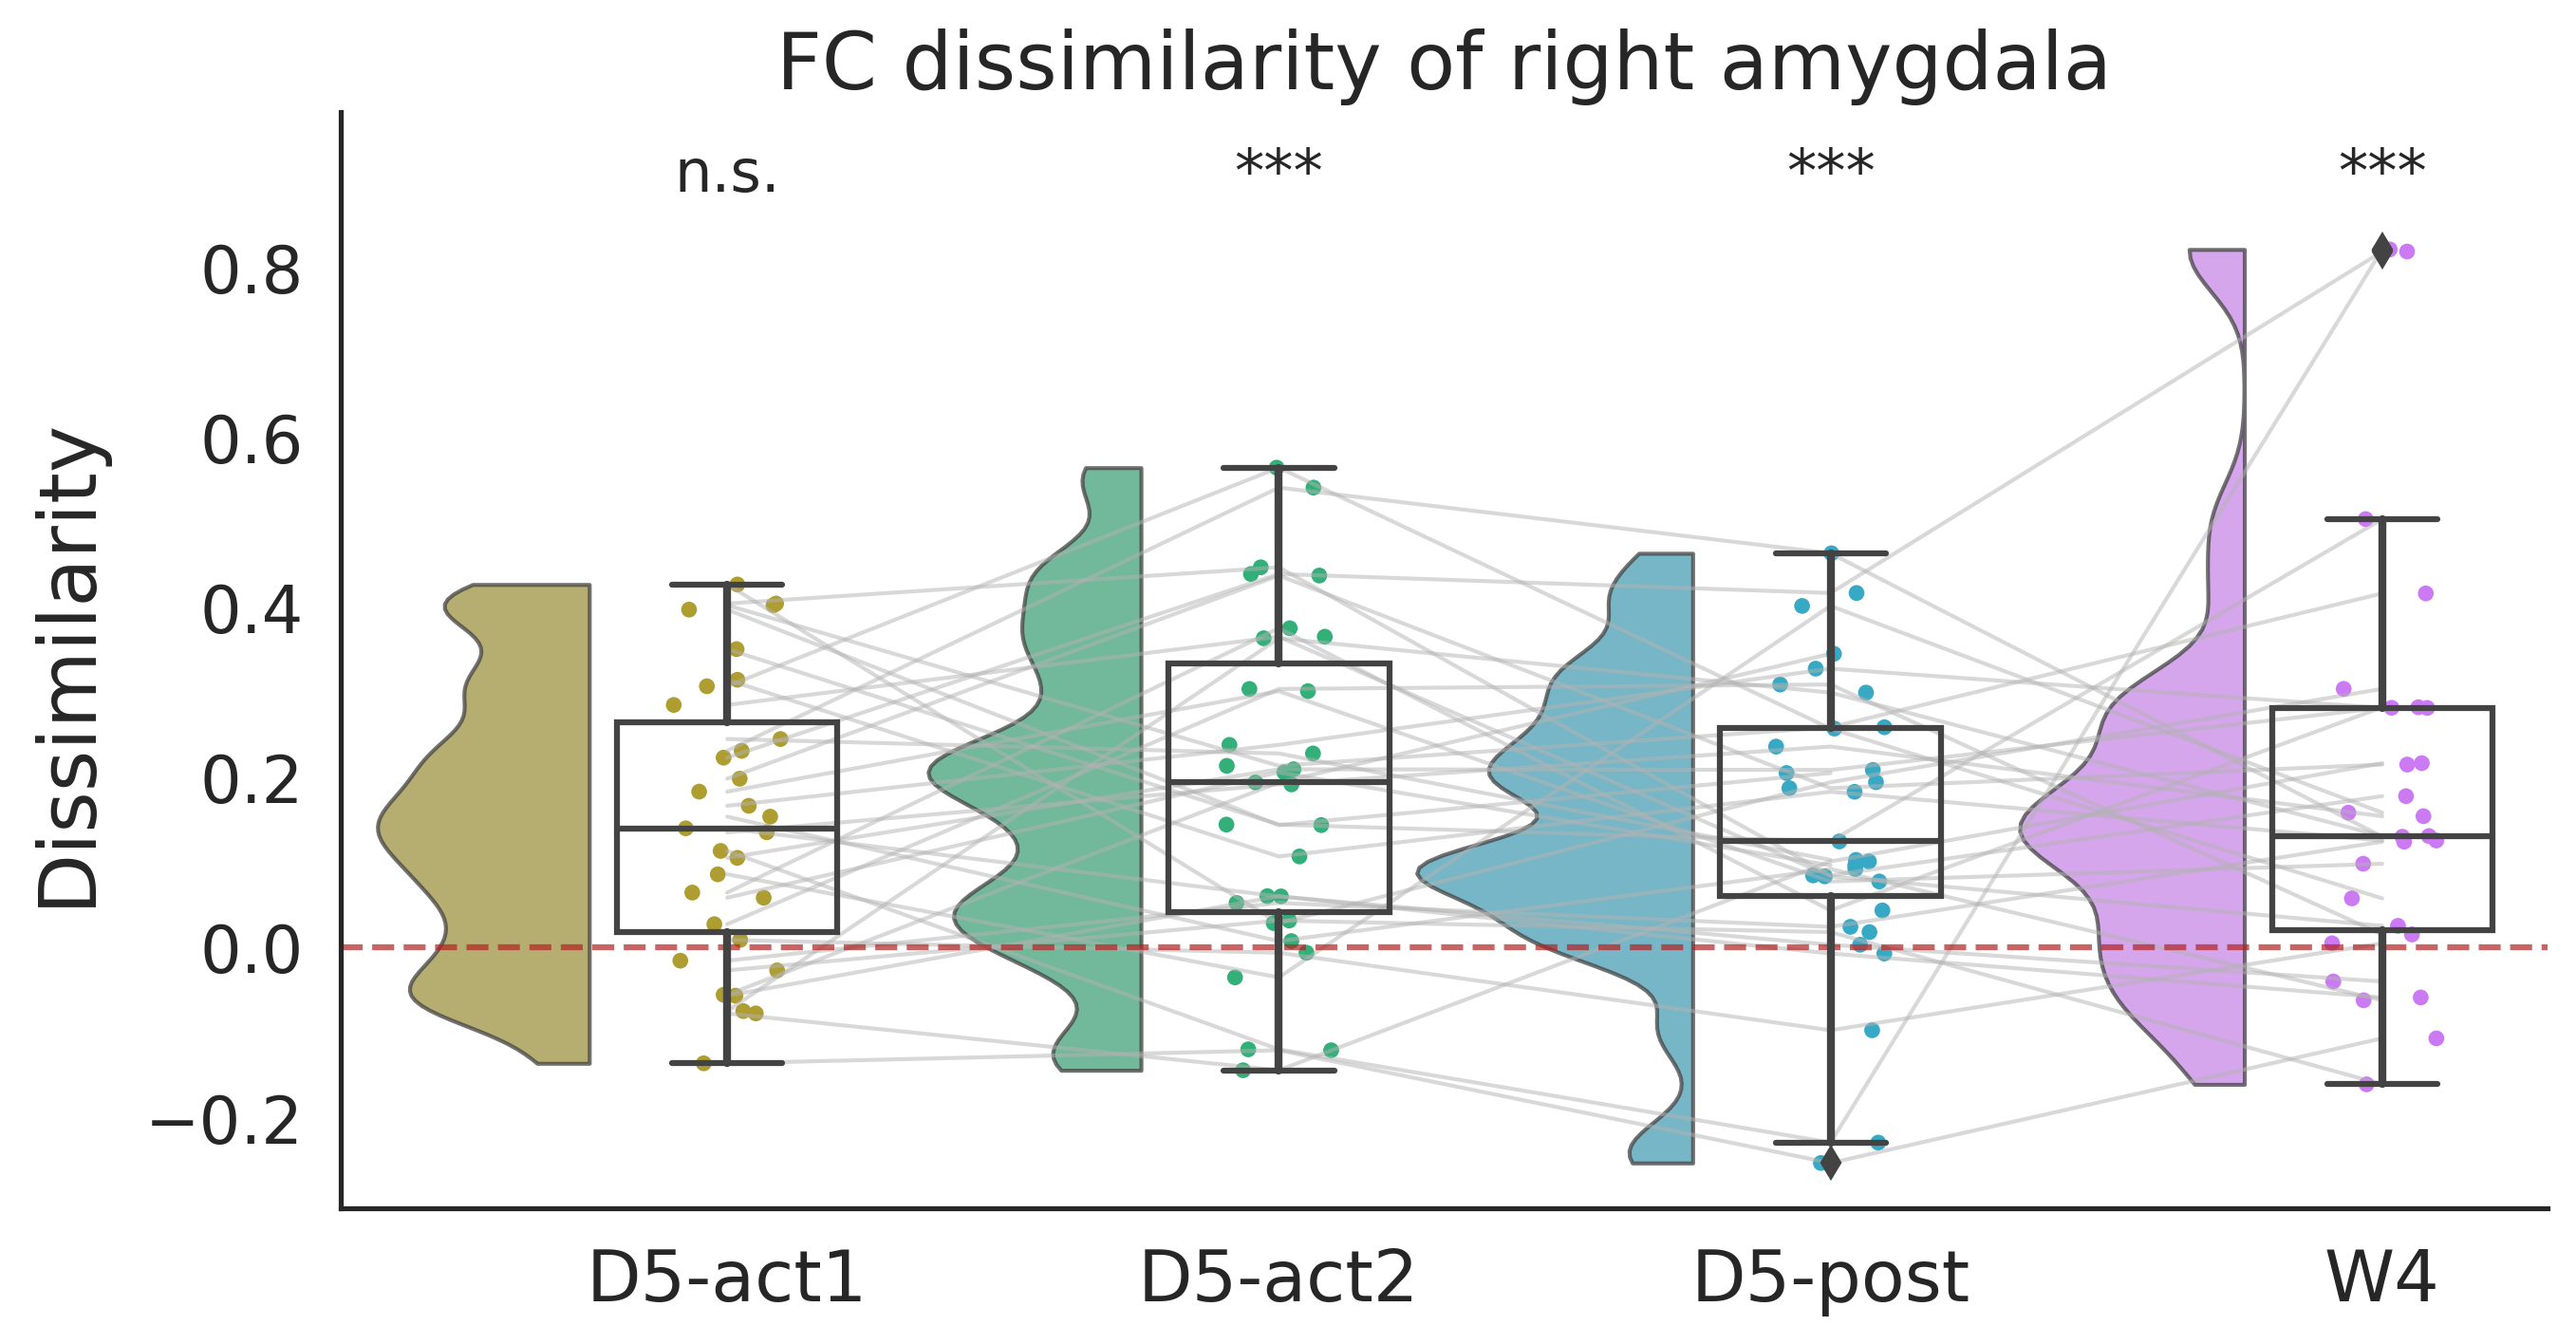

In [23]:
time_col = 'condition'
value_col = 'dissim'
time_order = ['5th_201','5th_301','5th_after','4weeks']
display_labels = ['D5-act1','D5-act2','D5-post','W4']
value_label = 'Dissimilarity'
subj_col = 'sub'

palette = sns.color_palette("husl", 5)[1:]
fig, ax = plt.subplots(figsize=(10,5),dpi=300)
pt.RainCloud(x=time_col, y=value_col, data=df, order=time_order, palette=palette,
                     bw=.2, width_viol=1, width_box=.4, offset=.25,alpha=.75, move=-0.0, ax=ax, orient='v',point_size=4)
# 调整边界
y_max = df[value_col].max()
y_min = df[value_col].min()
data_range = y_max - y_min
step = data_range*.15
ax.set_ylim(y_min - data_range*0.05,
            y_max + data_range*0.15)
ax.set_xlim(-.7,len(time_order)-.7)
## 设置标签
ax.set_xlabel('')
ax.set_xticklabels(display_labels, fontsize=18)
ax.set_xticks(range(len(time_order)))
ax.set_ylabel(value_label,labelpad=10, fontsize=20)
ax.set_title("FC dissimilarity of right amygdala",fontsize=20)
plt.axhline(0,color='#B22222',linestyle='--',alpha=0.7)
## 标注
plt.text(0,y_max + data_range*0.05,'n.s.',ha='center', va='bottom',fontsize=15)
plt.text(1,y_max + data_range*0.05,'***',ha='center', va='bottom',fontsize=15)
plt.text(2,y_max + data_range*0.05,'***',ha='center', va='bottom',fontsize=15)
plt.text(3,y_max + data_range*0.05,'***',ha='center', va='bottom',fontsize=15)

x_pos = {t: i for i, t in enumerate(time_order)}
for sid, g in df.groupby(subj_col):
    g = g.dropna(subset=[value_col]).sort_values(time_col, key=lambda x: x.map(x_pos))
    if g[time_col].nunique() >= 2:
        xs = [x_pos[t] for t in g[time_col]]
        ys = g[value_col].to_list()
        ax.plot(xs, ys, color='0.7', alpha=0.5, linewidth=1, zorder=1)